In [22]:
%matplotlib inline
%load_ext autoreload
%pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [4]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import skimage
import torch
import nibabel as nib

from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks

import pygalmesh
import meshio

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [5]:
%autoreload
dataset = project.copdgene.COPDGene(data_root='/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene')
dataset

COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=115)

In [6]:
def select_regions_by_size(mask, n_regions=1, min_size=0, verbose=True):
    
    # identify connected regions in the mask and measure their size
    regions = skimage.measure.label(mask, background=0)
    region_labels, region_sizes = np.unique(regions, return_counts=True)
    
    # compute the relative sizes of non-background regions
    relative_sizes = region_sizes / region_sizes[1:].sum() * 100
    print(np.round(relative_sizes[1:], 1))

    # sort the regions by size and select the n largest
    regions_by_size = np.argsort(-region_sizes)
    selected_regions = regions_by_size[1:1+n_regions]
    
    # keep only regions that are over the min relative size
    n_ok_size = (relative_sizes[1:] >= min_size).sum()
    selected_regions = selected_regions[:n_ok_size]

    # create new mask with only the selected regions
    new_mask = np.isin(regions, selected_regions).astype(mask.dtype)
    
    # compute how many voxels were affected
    old_count = (mask > 0).sum().astype(int)
    new_count = (new_mask).sum().astype(int)
    n_dropped = old_count - new_count
    pct_dropped = n_dropped / old_count * 100

    print(f'{n_dropped} voxels were dropped, {new_count} are left ({pct_dropped:.1f}% dropped)')
    if pct_dropped > 10:
        print(f'WARNING: {pct_dropped:.0f}% of voxels were dropped!')
        
    return new_mask

mask = np.array([
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
])
select_regions_by_size(mask, n_regions=10, min_size=15, verbose=True)

[40.  40.   6.7 13.3]
3 voxels were dropped, 12 are left (20.0% dropped)


array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [7]:
visit = dataset[0][0]
images = visit.load_images('Resized')
len(images)

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_SHARP_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_SHARP_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_STD_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-

4

In [8]:
total_task_rois = [
    'lung_upper_lobe_right',
    'lung_middle_lobe_right',
    'lung_lower_lobe_right',
    'lung_upper_lobe_left',
    'lung_lower_lobe_left'
]
vessel_task_rois = [
    'lung_trachea_bronchia',
    'lung_vessels'
]
all_task_rois = total_task_rois + vessel_task_rois

In [52]:
help(nib.save)

Help on function save in module nibabel.loadsave:

save(img: 'FileBasedImage', filename: 'FileSpec', **kwargs) -> 'None'
    Save an image to file adapting format to `filename`
    
    Parameters
    ----------
    img : ``SpatialImage``
       image to save
    filename : str or os.PathLike
       filename (often implying filenames) to which to save `img`.
    \*\*kwargs : keyword arguments
        Keyword arguments to format-specific save
    
    Returns
    -------
    None



In [53]:
%%time

def run_totalsegmentator_tasks(visit, image_name):
    image_file = visit.image_file('Resized', image_name)
    mask_file = visit.mask_file('TotalSegment', image_name, roi='lung_regions')
    mask_dir = mask_file.parent
    
    print('Running totalsegmentator task: total')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='total',
        roi_subset=total_task_rois,
    )
    print('Running totalsegmentator task: lung_vessels')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='lung_vessels'
    )
    print('Combine totalsegmentator masks')
    combined = combine_masks(
        mask_dir=mask_dir,
        class_type='lung'
    )
    combined_file = visit.mask_file('TotalSegment', image_name, roi='lung_combined_mask')
    nib.save(combined, combined_file)
    
    
run_totalsegmentator_tasks(visit, image_name='10009Y_EXP_SHARP_NJC_COPD')

Running totalsegmentator task: total

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 2.62s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 24.50s
Resampling...
  cropping from (256, 256, 256) to (230, 180, 244)
Resampling...
  Resampled in 2.01s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


  Predicted in 12.37s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.48s
Running totalsegmentator task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 2.69s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 9.00s
Resampling...
  cropping from (256, 256, 256) to (230, 180, 244)
Predicting...


100%|██████████| 100/100 [00:02<00:00, 33.44it/s]


  Predicted in 29.06s
Saving segmentations...


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
Creating lung_vessels.nii.gz
  Saved in 1.26s
Combine totalsegmentator masks
CPU times: user 23 s, sys: 7.27 s, total: 30.2 s
Wall time: 1min 35s


In [54]:
%autoreload
masks = visit.load_masks(image_dir='Resized', mask_dir='TotalSegment')

10009Y_EXP_SHARP_NJC_COPD
lung_combined_mask
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz (256, 256, 256)
lung_lower_lobe_left
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz (256, 256, 256)
lung_lower_lobe_right
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/1

In [55]:
len(masks)

1

In [56]:
masks[0]

<xarray.DataArray '10009Y_EXP_SHARP_NJC_COPD' (roi: 9, x: 256, y: 256, z: 256)> Size: 1GB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * roi      (roi) <U22 792B 'lung_combined_mask' ... 'lung_vessels'
  * x        (x) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * y        (y) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * z        (z) float64 2kB 0.0 1.169 2.338 3.507 ... 294.6 295.8 297.0 298.1

In [57]:
def xview(image, **kwargs):
    return project.visual.XArrayViewer(image, **kwargs)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

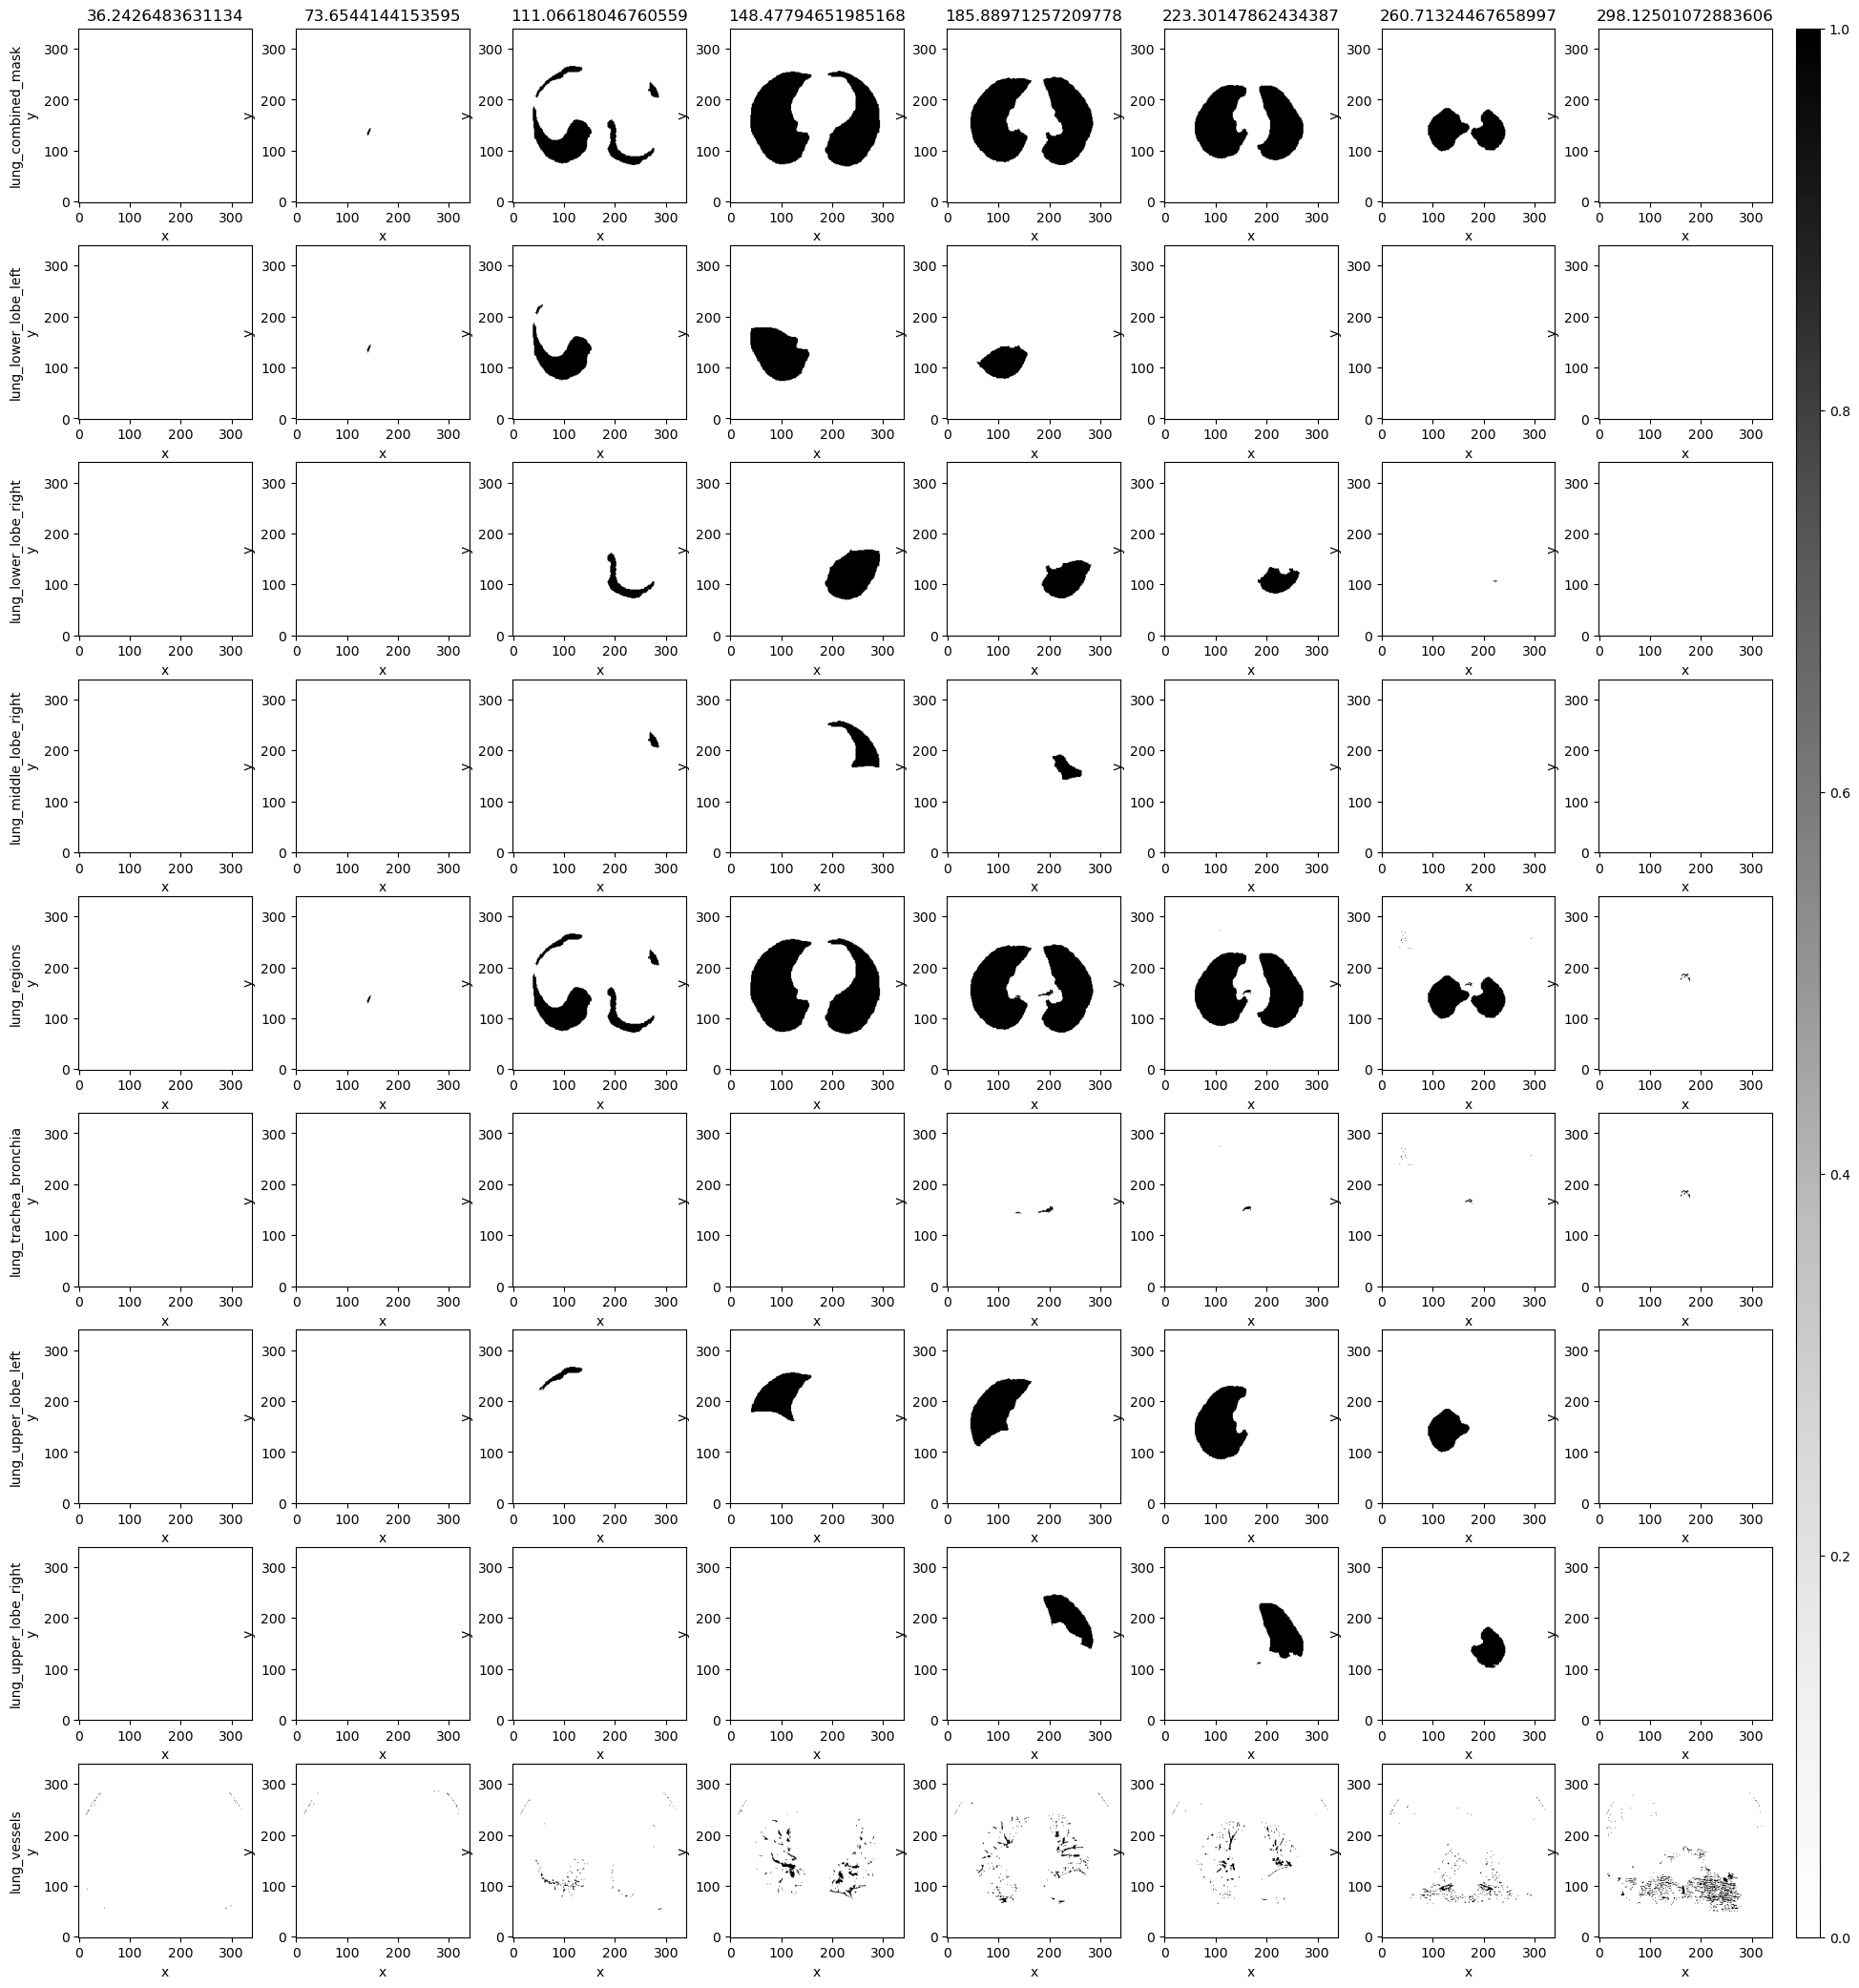

In [58]:
xview(masks[0][:,:,:,31::32], cmap='Greys', vmin=0, vmax=1, row='roi', col='z', ax_height=2, ax_width=2, space=0.25)

In [59]:
%%time
def clean_totalseg_masks(visit, image_name):
    assert all_task_rois[-1] == 'lung_vessels'

    print('Postprocessing totalseg masks')
    regions = []
    for i, roi in enumerate(all_task_rois):
        mask_file = visit.mask_file('TotalSegment', image_name, roi)
        
        print(f'Cleaning {mask_file}')
        mask_nifti = nib.load(mask_file)
        mask = mask_nifti.get_fdata()
        
        if roi != 'lung_vessels':
            new_mask = mask #select_regions_by_size(mask, n_regions=2)
    
        else: # lung_vessels
            new_mask = mask.astype(bool)
            new_mask |= skimage.morphology.skeletonize(mask)
            new_mask &= (np.stack(regions).sum(axis=0) > 0)
            new_mask = select_regions_by_size(new_mask.astype(float), n_regions=2)
        
        regions.append(new_mask * (i + 1))
    
    # combine into single region mask
    regions = np.stack(regions).max(axis=0)

    mask_file = visit.mask_file('TotalSegment', image_name, roi='lung_regions')
    print(f'Creating {mask_file}')
    mask_nifti = nib.nifti1.Nifti1Image(regions, mask_nifti.affine)
    nib.save(mask_nifti, mask_file)

    return regions
          
regions = clean_totalseg_masks(visit, image_name='10009Y_EXP_SHARP_NJC_COPD')
regions.shape

Postprocessing totalseg masks
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_upper_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_middle_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_upper_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_trachea_bronchia.nii.gz

(256, 256, 256)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

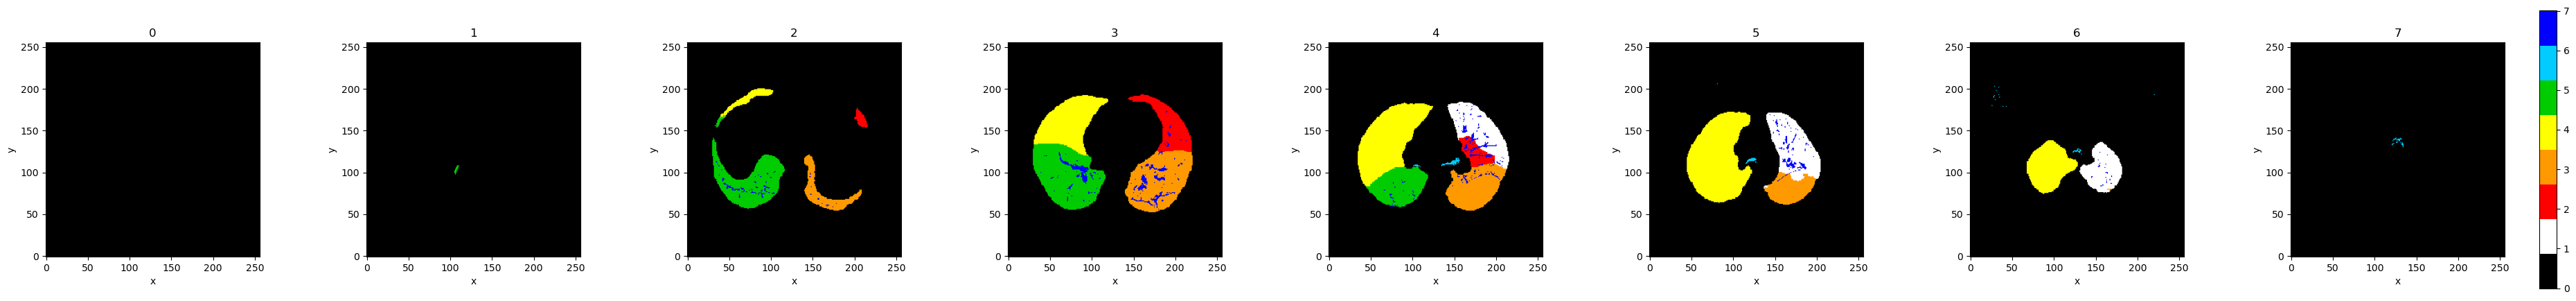

In [60]:
xview(project.utils.as_xarray(regions[:,:,31::32], name='regions', dims=['x', 'y', 'z']), col='z')

interactive(children=(Output(),), _dom_classes=('widget-interact',))

CPU times: user 15.7 s, sys: 176 ms, total: 15.8 s
Wall time: 15.9 s


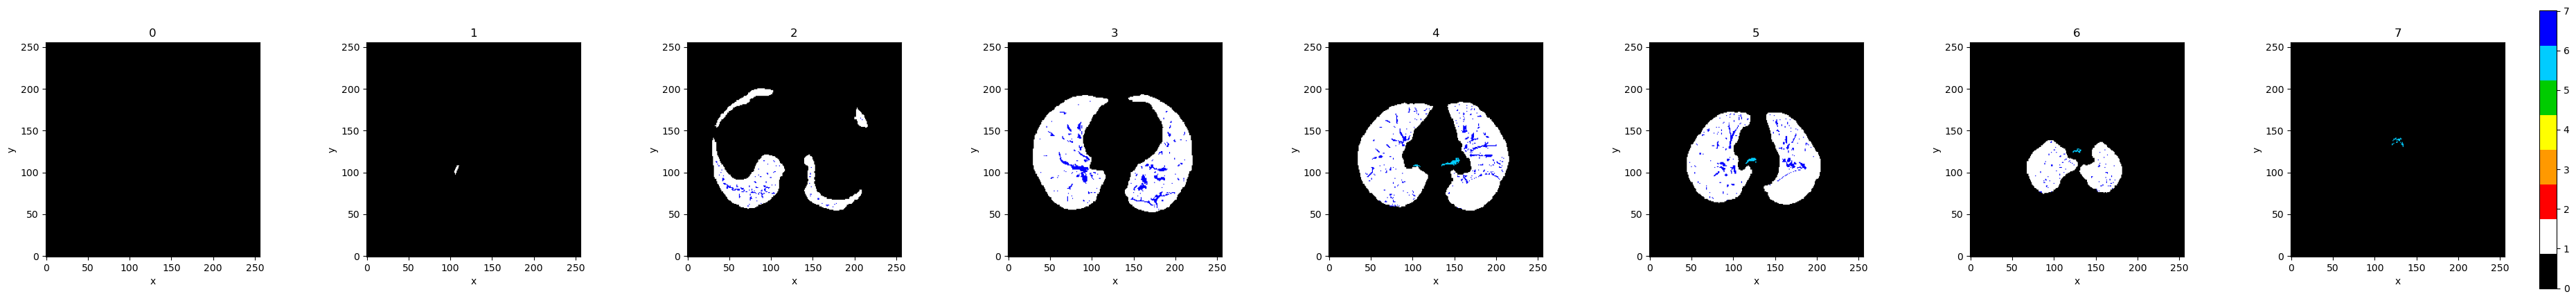

In [61]:
%%time
 
def create_lung_region_mask(visit, image_name, new_roi):
    print(f'Creating lung region mask for subject {visit.subject_id} visit {visit.visit_name} image {image_name}')
    regions = []
    
    lung_file = visit.mask_file('TotalSegment', image_name, roi='lung_combined_mask')
    lung_nifti = nib.load(lung_file)
    lung_mask = lung_nifti.get_fdata().astype(bool)
    lung_mask = select_regions_by_size(lung_mask, n_regions=2, min_size=30)
    regions.append(lung_mask)
    
    #lobes_file = case.medpseg_mask_file(phase, roi='lobes')
    #lobes_mask = nib.load(lobes_file).get_fdata().astype(int)
    #for i in range(5):
    #    lobe_mask = select_regions_by_size(lobes_mask == (i+1), n_regions=1)
    #    regions.append(lobe_mask * (i+1))
    
    airway_file = visit.mask_file('TotalSegment', image_name, roi='lung_trachea_bronchia')
    airway_mask = nib.load(airway_file).get_fdata().astype(bool)
    airway_mask = select_regions_by_size(airway_mask, n_regions=1)
    regions.append(airway_mask * 6)
    
    vessel_file = visit.mask_file('TotalSegment', image_name, roi='lung_vessels')
    vessel_mask = nib.load(vessel_file).get_fdata().astype(bool)
    vessel_mask |= skimage.morphology.skeletonize(vessel_mask)
    vessel_mask &= (lung_mask | airway_mask)
    regions.append(vessel_mask * 7)
    
    regions_file = visit.mask_file('TotalSegment', image_name, roi=new_roi)
    print(f'Saving {regions_file}')
    regions = np.stack(regions).max(axis=0).astype(np.uint16)
    regions_nifti = nib.nifti1.Nifti1Image(regions, lung_nifti.affine)
    nib.save(regions_nifti, regions_file)
    
    return regions

regions = create_lung_region_mask(visit, image_name='10009Y_EXP_SHARP_NJC_COPD', new_roi='lung_regions')
xview(project.utils.as_xarray(regions[:,:,31::32], name='regions', dims=['x', 'y', 'z']), col='z')

In [69]:
%autoreload

def generate_anatomical_mesh(visit, image_name, mask_roi, mesh_version):
    
    mask_file = visit.mask_file('TotalSegment', image_name, mask_roi)
    mask_nifti = nib.load(mask_file)
    mask = mask_nifti.get_fdata()
    resolution = mask_nifti.header.get_zooms()
    print(resolution)

    print('Generating mesh with pygalmesh')
    mesh = pygalmesh.generate_from_array(
        mask.astype(np.uint16),
        voxel_size=resolution,
        max_cell_circumradius={
            'default': 10.0,
            6: 5.0, # airways
            7: 2.0, # vessels
        },
        max_facet_distance=1.5,
        lloyd=True,
        odt=True
    )
    print('Postprocessing mesh')
    mesh = project.meshing.remove_unused_points(mesh)

    tetra_cells = mesh.get_cells_type('tetra')
    mesh.cells = [meshio.CellBlock('tetra', tetra_cells)]
    
    visit.mesh_dir('pygalmesh', image_name).mkdir(exist_ok=True, parents=True)
    mesh_file = visit.mesh_file('pygalmesh', image_name, mask_roi, mesh_version)
    print(f'Saving {mesh_file}')
    meshio.xdmf.write(mesh_file, mesh)

    mesh, cell_labels = project.meshing.load_mesh_fenics(mesh_file)  
    return mesh

generate_anatomical_mesh(visit, image_name='10009Y_EXP_SHARP_NJC_COPD', mask_roi='lung_regions', mesh_version=10)

(1.3307282, 1.3307282, 1.1691177)
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/pygalmesh/10009Y_EXP_SHARP_NJC_COPD/lung_regions_10.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/pygalmesh/10009Y_EXP_SHARP_NJC_COPD/lung_regions_10.xdmf... 18659


```






```

In [ ]:
%%time
for i, subject in enumerate(dataset.subjects):
    for j, visit in enumerate(subject.visits):
        for k, image_name in enumerate(visit.list_images('Resized')):
            print((i,j,k), visit.subject_id, visit.visit_name, image_name)
            run_totalsegmentator_tasks(visit, image_name)
            regions = create_lung_region_mask(visit, image_name, new_roi='lung_regions')
            mesh = generate_anatomical_mesh(visit, image_name, mask_roi='lung_regions', mesh_version=10)

100%|██████████| 8/8 [00:00<00:00, 68.85it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  0%|          | 0/2 [00:00<?, ?it/s]

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  0%|          | 0/5 [00:00<?, ?it/s]

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  0%|          | 0/2 [00:00<?, ?it/s]

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  0%|          | 0/5 [00:00<?, ?it/s]

Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T70_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T70_lung_regions2_11.xdmf... 20553
Creating lung region mask for Case7Pack phase 80
[54.6 45.4]
0 voxels were dropped, 471792 are left (0.0% dropped)
[98.   0.   0.   0.   1.4  0.   0.5  0.   0. ]
91 voxels were dropped, 4352 are left (2.0% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/TotalSegment/case7_T80/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T80_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T80_lung_regions2_11.xdmf... 20896
Creating lung region mask for Case7Pack phase 90
[54.6 45.4]
0 voxels were dropped, 490720 are l

[96.8  3.2]
72 voxels were dropped, 2192 are left (3.2% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/TotalSegment/case9_T10/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T10_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T10_lung_regions2_11.xdmf... 14126
Creating lung region mask for Case9Pack phase 20
[54.8 45.2]
0 voxels were dropped, 299292 are left (0.0% dropped)
[ 0.1 98.4  1.3  0.   0.1]
32 voxels were dropped, 1981 are left (1.6% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/TotalSegment/case9_T20/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T20_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emo

[100.   0.]
1 voxels were dropped, 4438 are left (0.0% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/TotalSegment/case10_T50/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T50_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T50_lung_regions2_11.xdmf... 16383
Creating lung region mask for Case10Pack phase 60
[60.6 39.4]
0 voxels were dropped, 558755 are left (0.0% dropped)
[ 0.  99.8  0.   0.1]
9 voxels were dropped, 4701 are left (0.2% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/TotalSegment/case10_T60/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T60_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT